In [1]:
from pygeotools.lib import  geolib, malib, iolib, warplib
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline
import rasterio, affine
from rasterio import features
import numpy as np
import pandas as pd
from IPython.display import Image
from scipy import stats

In [2]:
import matplotlib.pyplot as plt

#### Currently use  an already available wrapper around GSLIB https://github.com/GeostatsGuy/GeostatsPy/

In [38]:
import sys
GeoPy_path='/home/shashank/nobackup_shashank/gslib_executables/GeostatsPy/'
sys.path.insert(0, GeoPy_path)
import GeostatsPy

In [3]:
shp_fn='../../raster_geostatistics/data/Sikkim_kanchenjunga.shp'
raster_fn='../../raster_geostatistics/data/Rate_maps_Coregister-tile-0-last_inverted_ref.tif'

In [4]:
shp_gdf=gpd.read_file(shp_fn)
rasterio_dataset= rasterio.open(raster_fn)
gt_r=rasterio_dataset.transform
##### To convert back and forth from the gdal tuple to affine transform
#https://www.perrygeo.com/python-affine-transforms.html
gt_rp = gt_r.to_gdal()
array_rasterio_masked=rasterio_dataset.read(1, masked=True)

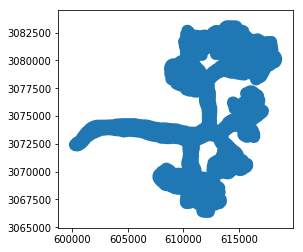

In [5]:
shp_gdf_projected_raster=shp_gdf.copy()
shp_gdf_projected_raster=shp_gdf_projected_raster.to_crs(rasterio_dataset.crs)
shp_gdf_projected_buffer=shp_gdf_projected_raster.copy()
shp_gdf_projected_buffer['geometry']=shp_gdf_projected_buffer.buffer(500)
shp_gdf_projected_buffer.plot()

In [13]:
type(shp_gdf_projected_buffer.geometry)

geopandas.geoseries.GeoSeries

In [28]:
from geopandas import GeoSeries
GeoSeries(shp_gdf_projected_buffer.geometry.values[0])

0    POLYGON ((599950.9148779241 3072879.162204025,...
dtype: object

In [15]:
shape_array=features.rasterize(shp_gdf_projected_buffer.geometry, out_shape=array_rasterio_masked.shape,fill=-9999,transform=rasterio_dataset.transform,dtype=float)
shape_masked=np.ma.masked_where(shape_array==-9999, shape_array)
glacier_cutoff=np.ma.array(array_rasterio_masked, mask=shape_masked.mask)

TypeError: 'Polygon' object is not iterable

### Trimming the masked array and associated gt

In [43]:
##*****Potential Function******##
#trim the array
trim_ar=malib.masktrim(glacier_cutoff)
#trim the gt
print("input gt", gt_r)
edge_env = malib.edgefind2(glacier_cutoff)
out_gt=list(gt_rp)
#update UL_X
out_gt[0] = gt_rp[0] + gt_rp[1]*edge_env[2]
#Update UL_y
out_gt[3] = gt_rp[3] + gt_rp[5]*edge_env[0]
out_gt = tuple(out_gt)
#convert to rasterio gt
out_gt_r=affine.Affine.from_gdal(*out_gt)
print("Output gt",out_gt_r)

input gt | 10.00, 0.00, 551333.39|
| 0.00,-10.00, 3115850.78|
| 0.00, 0.00, 1.00|
Output gt | 10.00, 0.00, 599713.39|
| 0.00,-10.00, 3083580.78|
| 0.00, 0.00, 1.00|


### Reading xyz

In [44]:
x, y = geolib.get_xy_ma(trim_ar, gt=out_gt, origmask=True)
xyz = np.vstack((x.compressed(),y.compressed(),trim_ar.compressed())).T
df=pd.DataFrame(xyz,columns=['x','y','dh'])
df.head()

,x,y,dh
0,613748.392595,3.083576e+06,-0.436620
1,613668.392595,3.083546e+06,-9.811455
2,613648.392595,3.083536e+06,-4.753187
3,613658.392595,3.083536e+06,-8.136490
4,613668.392595,3.083536e+06,-10.443363


### Declusterring data, assigning them wiegths


In [ ]:
#weights=GeostatsPy.declus(df,'x','y','dh',100,1000,5,0)

### nscore transform

In [ ]:
dh_nscore=GeostatsPy.nscore(df.dh.values,df.dh.count())
#### Error in data file problem, this expects a datafile, it probably expects a data

In [ ]:
df.dh.values

In [ ]:
dh_nscore.head(4)

In [ ]:
hist=dh_nscore.hist()

In [ ]:
df=df.assign(nscore=dh_nscore['NS:value'].values)

In [ ]:
df.tail()

#### Major Update:- If we compute the experimental semivariogram with azimuth of 0 degree(east-west) and put tolerance values of 90 degrees, the obtained variogram will pick up points from the entire 2d grid!
### This is how it is done is softwares such as ARC GIS, Golden, Surfer etc!

In [ ]:
Image('semivariogram_example_golden.png')

#### experimental variogram

In [ ]:
lag,gamma,npair=GeostatsPy.gamv_2d(df,'x','y','nscore',300,10,0,90,1)


In [ ]:
lag_ns,gamma_ns,npair_ns=GeostatsPy.gamv_2d(df,'x','y','nscore',100,10,0,90,0)

In [46]:
def plt_variogram(lag,gamma,npair):
    sat=plt.scatter(lag,gamma,c=npair)
    plt.ylim(0,1)
    plt.grid()
    cb = plt.colorbar(sat, spacing='proportional',label='No of pairs')
    plt.yticks(np.arange(0,1.15,0.05))
    plt.xticks(np.arange(0,3100,300))
    plt.xlabel('Lag Distance (m)')
    plt.ylabel('Variance (m^2)')
    plt.plot()  

In [ ]:
plt_variogram(lag,gamma,npair)

In [ ]:
gamma[2:4]

### As per literature, Sill = variance of data, for nscored data, this is equal to 1
### We use range as the lag distance at which first sill is achieved (Assumption)
### Nugget is the intercept obtained by fitting a line to first two non zero lags (Reference)


def model_param(lag,gamma,npair):
    sill=1
    print('Sill=',sill)
    idx=np.argmax(np.array(gamma)>sill)
    print(idx)
    vrange=lag[idx]
    print("Range =",vrange)
    x=lag[0:4]
    y=gamma[0:4]
    slope,nugget,r,p,std=stats.linregress(x,y)
    print("Nugget=",nugget)
    return (nugget,sill,vrange)

In [ ]:
GeostatsPy.vmodel_2d()

In [ ]:
np.var(df.nscore.values)

In [ ]:
plt.scatter(lag,gamma)
plt.ylim(0,1)
plt.grid()
plt.yticks([0,0.05,0.1,0.15,0.2,0.25,0.30,0.35,0.40,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1])

In [ ]:
lag180,gamma180,npair180=GeostatsPy.gamv_2d(df,'x','y','nscore',300,10,0,180,1)
lag360,gamma360,npair360=GeostatsPy.gamv_2d(df,'x','y','nscore',300,10,0,360,1)


In [ ]:
plt_variogram(lag180,gamma180,npair180)

In [ ]:
plt_variogram(lag360,gamma360,npair360)

In [ ]:
def find_range():
    
    
    return range_value

In [ ]:
#lag_y,gamma_y,npair_y=GeostatsPy.gamv_2d(df,'x','y','nscore',20,10,0,0,1)

In [ ]:
#gamma_y

In [ ]:
lag_mod,gamma_mod = GeostatsPy.vmodel_2d(nlag=100,azi=90 ,step=10,nug=0,nst=1,tstr1=1,c1=1.0,azi1=90,rmaj1=700,rmin1=430)

#### Modeled spherical variogram and plotting

In [ ]:
lags=np.array([lag_x,lag_y])
gammas=np.array([gamma_x,gamma_y])
vtype=[0,0]
name=['Azi 00','Azi 90']
lag_x_mod,gamma_x_mod = GeostatsPy.vmodel_2d(nlag=20,azi=90,step=10,nug=0,nst=1,tstr1=1,c1=1.0,azi1=90,rmaj1=700,rmin1=430)
lag_y_mod,gamma_y_mod = GeostatsPy.vmodel_2d(nlag=20,azi=0,step=10,nug=0,nst=1,tstr1=1,c1=1.0,azi1=90,rmaj1=700,rmin1=430)

lags = np.array([lag_x,lag_y,lag_x_mod,lag_y_mod])                # combine into in lists of arrays to pass to plotting
gammas = np.array([gamma_x,gamma_y,gamma_x_mod,gamma_y_mod])
npairs = np.array([npair_x,npair_y])
vtype = [0,0,1,1]                                                 # indicate that the two variograms are experimental
name = ['Azi 090','Azi 000','Model 090','Model 000']              # give the variograms names
GeostatsPy.vargplts(lags,gammas,npairs,vtype,name,0,700,0,1.2,1,"Test of Experimental and Model Variogram Calculation and Visualization",plt.cm.plasma)


## To Do
#### nscore, experimental and model variogram done, fix error in plotting section of wrapper and try to attempt SGSIM
### error fixed, run with higher number of lags and check conditioning for modeled variogram
#### attempt SGSIM

In [ ]:
gamma_x_mod

### Random Sample Experiment

In [ ]:
df.head()

In [ ]:
df_random=df.sample(n=10000)

In [ ]:
df_random.dh.count()

In [ ]:
dh_nscored=GeostatsPy.nscore(df_random.dh.values,df_random.dh.count())

In [ ]:
df_random=df_random.assign(nscored_f=dh_nscored['NS:value'].values)

In [ ]:
df_random.nscored_f.hist()

In [ ]:
lag_sample,gamma_sample,npair_sample=GeostatsPy.gamv_2d(df_random,'x','y','nscored_f',300,10,0,90,1)
lag180_sample,gamma180_sample,npair180_sample=GeostatsPy.gamv_2d(df_random,'x','y','nscored_f',300,10,0,180,1)
lag360_sample,gamma360_sample,npair360_sample=GeostatsPy.gamv_2d(df_random,'x','y','nscored_f',300,10,0,360,1)

In [ ]:
plt_variogram(lag_sample,gamma_sample,npair_sample)

In [ ]:
plt_variogram(lag180_sample,gamma180_sample,npair180_sample)

In [ ]:
plt_variogram(lag360_sample,gamma360_sample,npair360_sample)

In [ ]:
#Full region stats
nugget,sill,vrange=model_param(lag,gamma,npair)
#10000 Sample stats
nugget_samp,sill_samp,vrange_samp=model_param(lag_sample,gamma_sample,npair_sample)

In [ ]:
lag,gamma,npair=GeostatsPy.gamv_2d(df,'x','y','nscore',300,10,0,90,1)
lag180,gamma180,npair180=GeostatsPy.gamv_2d(df,'x','y','nscore',300,10,0,180,1)
lag360,gamma360,npair360=GeostatsPy.gamv_2d(df,'x','y','nscore',300,10,0,360,1)

In [ ]:
plt_variogram(lag,gamma,npair)

In [ ]:
plt_variogram(lag360,gamma360,npair360)

In [ ]:
df_full=pd.DataFrame('lag'=lag,'gamma'=gamma,npair='npair')

In [ ]:
#d_full_90={'lag':lag,'gamma':gamma,'npair':npair}
#df_full_90=pd.DataFrame(d_full_90)

In [ ]:
df_full_90.tail()

In [ ]:
#d_full_180={'lag':lag180,'gamma':gamma180,'npair':npair180}
#df_full_180=pd.DataFrame(d_full_180)

In [ ]:
#d_full_360={'lag':lag360,'gamma':gamma360,'npair':npair360}
#df_full_360=pd.DataFrame(d_full_360)

In [ ]:
#df_full_90.to_csv('Full_data_90.csv')
#df_full_180.to_csv('Full_data_180.csv')
#df_full_360.to_csv('Full_data_360.csv')

### 50000 Sample Test Case

In [ ]:
df_random=df.sample(n=50000)
dh_nscored=GeostatsPy.nscore(df_random.dh.values,df_random.dh.count())
df_random=df_random.assign(nscored_f=dh_nscored['NS:value'].values)
lag_sample,gamma_sample,npair_sample=GeostatsPy.gamv_2d(df_random,'x','y','nscored_f',300,10,0,90,1)
lag180_sample,gamma180_sample,npair180_sample=GeostatsPy.gamv_2d(df_random,'x','y','nscored_f',300,10,0,180,1)
lag360_sample,gamma360_sample,npair360_sample=GeostatsPy.gamv_2d(df_random,'x','y','nscored_f',300,10,0,360,1)

In [ ]:
plt_variogram(lag360_sample,gamma360_sample,npair360_sample)

In [ ]:
plt_variogram(lag180_sample,gamma180_sample,npair180_sample)

In [ ]:
plt_variogram(lag_sample,gamma_sample,npair_sample)

In [ ]:
#Full region stats
nugget,sill,vrange=model_param(lag,gamma,npair)
#50000 Sample stats
nugget_samp,sill_samp,vrange_samp=model_param(lag_sample,gamma_sample,npair_sample)

### 40000 points sub_sample





In [ ]:
df_random=df.sample(n=40000)
dh_nscored=GeostatsPy.nscore(df_random.dh.values,df_random.dh.count())
df_random=df_random.assign(nscored_f=dh_nscored['NS:value'].values)
lag_sample,gamma_sample,npair_sample=GeostatsPy.gamv_2d(df_random,'x','y','nscored_f',300,10,0,90,1)
lag180_sample,gamma180_sample,npair180_sample=GeostatsPy.gamv_2d(df_random,'x','y','nscored_f',300,10,0,180,1)
lag360_sample,gamma360_sample,npair360_sample=GeostatsPy.gamv_2d(df_random,'x','y','nscored_f',300,10,0,360,1)

In [ ]:
#Full region stats
nugget,sill,vrange=model_param(lag,gamma,npair)
#40000 Sample stats
nugget_samp,sill_samp,vrange_samp=model_param(lag_sample,gamma_sample,npair_sample)

In [ ]:
plt_variogram(lag360_sample,gamma360_sample,npair360_sample)

In [ ]:
plt_variogram(lag180_sample,gamma180_sample,npair180_sample)


In [ ]:
plt_variogram(lag_sample,gamma_sample,npair_sample)

### 10000 points sub_sample


In [ ]:
df_random=df.sample(n=10000)
dh_nscored=GeostatsPy.nscore(df_random.dh.values,df_random.dh.count())
df_random=df_random.assign(nscored_f=dh_nscored['NS:value'].values)
lag_sample,gamma_sample,npair_sample=GeostatsPy.gamv_2d(df_random,'x','y','nscored_f',300,10,0,90,1)
lag180_sample,gamma180_sample,npair180_sample=GeostatsPy.gamv_2d(df_random,'x','y','nscored_f',300,10,0,180,1)
lag360_sample,gamma360_sample,npair360_sample=GeostatsPy.gamv_2d(df_random,'x','y','nscored_f',300,10,0,360,1)

In [ ]:
#Full region stats
nugget,sill,vrange=model_param(lag,gamma,npair)
#10000 Sample stats
nugget_samp,sill_samp,vrange_samp=model_param(lag_sample,gamma_sample,npair_sample)

### 1000 points sub_sample


In [ ]:
df_random=df.sample(n=1000)
dh_nscored=GeostatsPy.nscore(df_random.dh.values,df_random.dh.count())
df_random=df_random.assign(nscored_f=dh_nscored['NS:value'].values)
lag_sample,gamma_sample,npair_sample=GeostatsPy.gamv_2d(df_random,'x','y','nscored_f',300,10,0,90,1)
lag180_sample,gamma180_sample,npair180_sample=GeostatsPy.gamv_2d(df_random,'x','y','nscored_f',300,10,0,180,1)
lag360_sample,gamma360_sample,npair360_sample=GeostatsPy.gamv_2d(df_random,'x','y','nscored_f',300,10,0,360,1)

In [ ]:
#Full region stats
nugget,sill,vrange=model_param(lag,gamma,npair)
#1000 Sample stats
nugget_samp,sill_samp,vrange_samp=model_param(lag_sample,gamma_sample,npair_sample)

### 5000 points sub_sample

In [ ]:
df_random=df.sample(n=5000)
dh_nscored=GeostatsPy.nscore(df_random.dh.values,df_random.dh.count())
df_random=df_random.assign(nscored_f=dh_nscored['NS:value'].values)
lag_sample,gamma_sample,npair_sample=GeostatsPy.gamv_2d(df_random,'x','y','nscored_f',300,10,0,90,1)
lag180_sample,gamma180_sample,npair180_sample=GeostatsPy.gamv_2d(df_random,'x','y','nscored_f',300,10,0,180,1)
lag360_sample,gamma360_sample,npair360_sample=GeostatsPy.gamv_2d(df_random,'x','y','nscored_f',300,10,0,360,1)

In [ ]:
#Full region stats
nugget,sill,vrange=model_param(lag,gamma,npair)
#5000 Sample stats
nugget_samp,sill_samp,vrange_samp=model_param(lag_sample,gamma_sample,npair_sample)

### 9000 points sub_sample


In [ ]:
df_random=df.sample(n=9000)
dh_nscored=GeostatsPy.nscore(df_random.dh.values,df_random.dh.count())
df_random=df_random.assign(nscored_f=dh_nscored['NS:value'].values)
lag_sample,gamma_sample,npair_sample=GeostatsPy.gamv_2d(df_random,'x','y','nscored_f',300,10,0,90,1)
lag180_sample,gamma180_sample,npair180_sample=GeostatsPy.gamv_2d(df_random,'x','y','nscored_f',300,10,0,180,1)
lag360_sample,gamma360_sample,npair360_sample=GeostatsPy.gamv_2d(df_random,'x','y','nscored_f',300,10,0,360,1)

In [ ]:
#Full region stats
nugget,sill,vrange=model_param(lag,gamma,npair)
#9000 Sample stats
nugget_samp,sill_samp,vrange_samp=model_param(lag_sample,gamma_sample,npair_sample)

In [ ]:
#Variogram Model

In [ ]:
lag_mod,gam_mod=GeostatsPy.vmodel_2d(nlag=300,step=10,azi=0,nug=0,nst=1,tstr1=1,c1=1,azi1=0,rmaj1=2380,rmin1=0.1)

In [ ]:
plt_variogram(lag_mod,gam_mod,npair)

#### Comparing omnidirectional, north_south and east_west direction variograms

In [73]:
df_random=df.sample(n=18000)
df_random.x=df_random.x.round(1)
df_random.y=df_random.y.round(1)

dh_nscored=GeostatsPy.nscore(df_random.dh.values,df_random.dh.count())
df_random=df_random.assign(nscored_f=dh_nscored['NS:value'].values)
lag_sample,gamma_sample,npair_sample=GeostatsPy.gamv_2d(df_random,'x','y','nscored_f',300,10,0,90,1)
lag_ns_sample,gamma_ns_sample,npairP_ns_sample=GeostatsPy.gamv_2d(df_random,'x','y','nscored_f',300,10,0,10,1)
lag_ew_sample,gamma_ew_sample,npair_ew_sample=GeostatsPy.gamv_2d(df_random,'x','y','nscored_f',300,10,90,10,1)

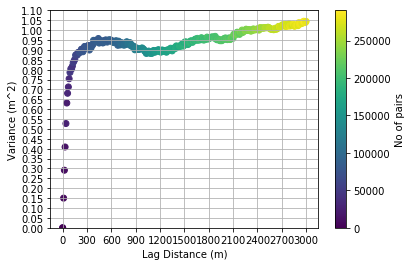

In [74]:
plt_variogram(lag_sample,gamma_sample,npair_sample)

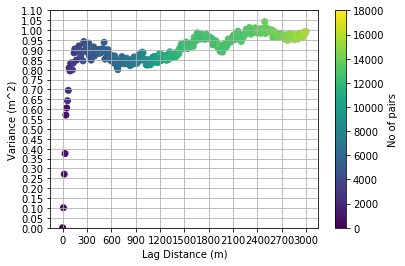

In [75]:
plt_variogram(lag_ns_sample,gamma_ns_sample,npairP_ns_sample)

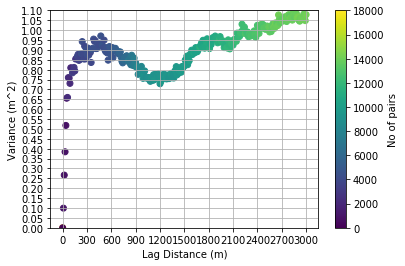

In [76]:
plt_variogram(lag_ew_sample,gamma_ew_sample,npair_ew_sample)

In [77]:
#East_west region stats
nugget_ew,sill_ew,vrange_ew=model_param(lag_ew_sample,gamma_ew_sample,npair_ew_sample)
#North_south Sample stats
nugget_ns,sill_ns,vrange_ns=model_param(lag_ns_sample,gamma_ns_sample,npairP_ns_sample)

Sill= 1
222
Range = 2210.331
Nugget= -0.0061563636363636265
Sill= 1
227
Range = 2260.556
Nugget= -0.006170909090909074


In [52]:
xmn,ymn,arb,aar1=rasterio_dataset.bounds

In [53]:
xmn

551333.3925950001

In [54]:
y[0,-1]

masked

In [55]:
np.shape(glacier_cutoff)

(8653, 16353)

In [56]:
np.shape(trim_ar)

(1763, 1916)

In [57]:
ny,nx=np.shape(trim_ar)

In [58]:
xmn = min(out_gt[0], out_gt[0] + nx * out_gt[1])
ymn = min(out_gt[3], out_gt[3] + ny * out_gt[5])


In [59]:
res=xsiz=ysiz=1000

In [60]:
ysiz

1000

In [78]:
sgsim=GeostatsPy.GSLIB_sgsim_2d_cond(df_random,'x','y','nscored_f',2,xmn,ymn,nx,ny,res,7480751,2260.56,2210.33,90,'sgsim_2.out')

StopIteration: 

In [65]:
df_random.x=df_random.x.round(1)

In [66]:
df_random.y=df_random.x.round(1)

In [67]:
df_random.dh=df_random.dh.round(2)

In [68]:
df_random.head()

,x,y,dh,nscored_f
282355,612688.4,612688.4,-9.06,-2.02425
199126,610518.4,610518.4,-1.14,-0.81775
46692,614418.4,614418.4,-0.11,0.03475
25792,618318.4,618318.4,-0.15,-0.00856
102283,612388.4,612388.4,-0.25,-0.12264
